In [101]:
def one_hot_encode(seq):
    mapping = {'A': [1, 0, 0, 0], 'C': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'T': [0, 0, 0, 1], 'N': [0, 0, 0, 0]}
    return np.array([mapping[nucleotide] for nucleotide in seq])

78131 32879 671372
(98637, 2)
[0 1 2]
(98637, 600)


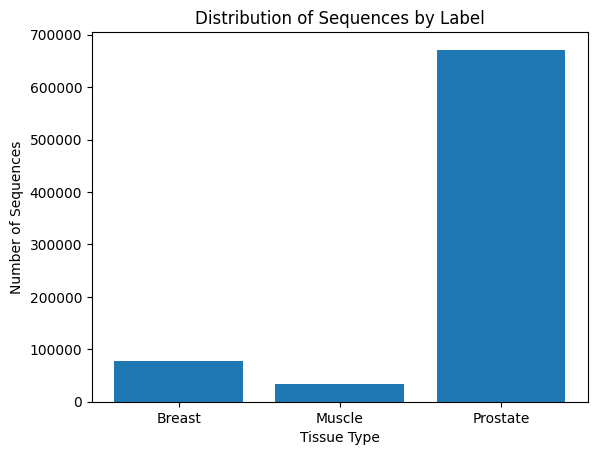

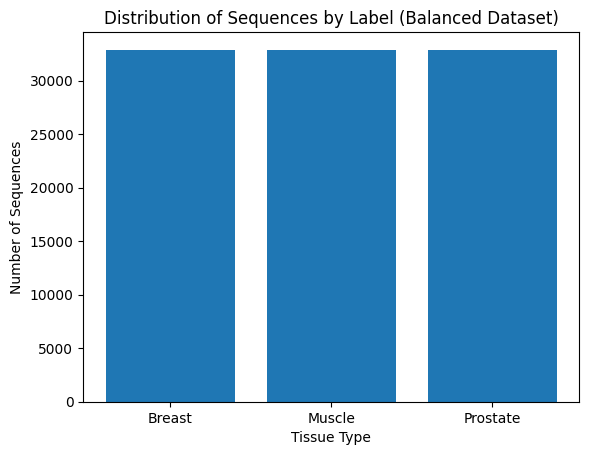

Breast Nucleotide Counts: {'A': 1179164, 'C': 1280001, 'G': 1293101, 'T': 1179583, 'N': 1} 

Muscle Nucleotide Counts: {'A': 1480741, 'C': 995880, 'G': 999878, 'T': 1455351, 'N': 0} 

Prostate Nucleotide Counts: {'A': 1429343, 'C': 1032615, 'G': 1042088, 'T': 1427804, 'N': 0} 



In [102]:
import pandas as pd
from sklearn.utils import resample
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.layers import Dropout
import seaborn as sns
from sklearn.metrics import confusion_matrix, log_loss
import tensorflow as tf

!pip install logomaker

#read in dna sequences
sequences_df = pd.read_csv('labeled_150bp_sequences.tsv', sep='\t')

#two of my datasets have way more sequences than the muscle so I need to
#downsample them
# Separate the dataframe by label
df_1 = sequences_df[sequences_df['label'] == 0]
df_2 = sequences_df[sequences_df['label'] == 1]
df_3 = sequences_df[sequences_df['label'] == 2]

print(len(df_1), len(df_2), len(df_3))

label_counts = [len(df_1), len(df_2), len(df_3)]
labels = ['Breast', 'Muscle', 'Prostate']




# Downsample the majority classes to match the size of the minority class
n_samples = len(df_2)
df_1_downsampled = resample(df_1, replace=False, n_samples=n_samples, random_state=42)
df_3_downsampled = resample(df_3, replace=False, n_samples=n_samples, random_state=42)

# Combine the downsampled dataframes
balanced_df = pd.concat([df_1_downsampled, df_2, df_3_downsampled])

print(balanced_df.shape)

balanced_df_1 = balanced_df[balanced_df['label'] == 0]
balanced_df_2 = balanced_df[balanced_df['label'] == 1]
balanced_df_3 = balanced_df[balanced_df['label'] == 2]

# Get the counts for each label in the balanced dataset
balanced_label_counts = [len(balanced_df_1), len(balanced_df_2), len(balanced_df_3)]





#this makes all the sequences uppercase
balanced_df['sequence'] = balanced_df['sequence'].str.upper()


# Apply one-hot encoding
balanced_df['encoded'] = balanced_df['sequence'].apply(one_hot_encode)

# Prepare data for Logistic Regression
X = np.array([x.flatten() for x in balanced_df['encoded'].tolist()])
y = balanced_df['label'].values

print(np.unique(y))

print(X.shape)


# Create the bar plot
plt.bar(labels, label_counts)
plt.xlabel('Tissue Type')
plt.ylabel('Number of Sequences')
plt.title('Distribution of Sequences by Label')
plt.show()


# Create the bar plot for the balanced dataset
plt.bar(labels, balanced_label_counts)
plt.xlabel('Tissue Type')
plt.ylabel('Number of Sequences')
plt.title('Distribution of Sequences by Label (Balanced Dataset)')
plt.show()


num_Breast_nucleotide = {'A': 0, 'C': 0,'G': 0, 'T': 0, 'N':0}
num_Muscle_nucleotide = {'A': 0, 'C': 0,'G': 0, 'T': 0, 'N':0}
num_Prostate_nucleotide = {'A': 0, 'C': 0,'G': 0, 'T': 0, 'N':0}

for _, rows in balanced_df.iterrows():
    label = rows['label']
    sequence = rows['sequence']

    if label == 0:
        for nucleotide in sequence:
            num_Breast_nucleotide[nucleotide]+=1

    if label == 1:
        for nucleotide in sequence:
            num_Muscle_nucleotide[nucleotide]+=1

    if label == 2:
        for nucleotide in sequence:
            num_Prostate_nucleotide[nucleotide]+=1


print("Breast Nucleotide Counts:", num_Breast_nucleotide , '\n')
print("Muscle Nucleotide Counts:", num_Muscle_nucleotide , '\n')
print("Prostate Nucleotide Counts:", num_Prostate_nucleotide , '\n')







/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Training Accuracy: 0.49938536795549304
Validation Accuracy: 0.48423560421735606
AUROC for class 1: 0.3315423493095681
AUROC for class 2: 0.6118431670818403
AUROC for class 3: nan


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


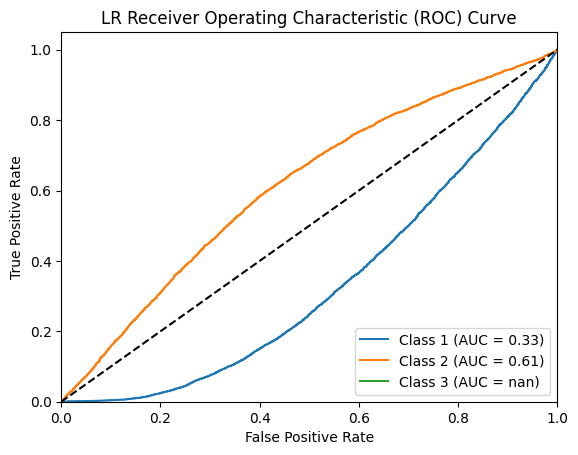

In [103]:
model_results_validation_accuracy = []
model_results_validation_loss = []

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Initialize Multinomial Logistic Regression model
log_reg = LogisticRegression(penalty='l1',solver='saga', max_iter=50, random_state=42)
# Changed multi_class to 'multinomial'


#Instead of partial_fit, use fit to train on the entire dataset at once
log_reg.fit(X_train, y_train)

# Calculate and store training accuracy
train_acc = log_reg.score(X_train, y_train)

y_pred_prob = log_reg.predict_proba(X_test)
val_loss = log_loss(y_test, y_pred_prob)
# Calculate and store validation accuracy
val_acc = log_reg.score(X_test, y_test)
model_results_validation_accuracy.append(val_acc)
model_results_validation_loss.append(val_loss)

print("Training Accuracy:", train_acc)
print("Validation Accuracy:", val_acc)

# After training the Logistic Regression model:
y_pred_prob = log_reg.predict_proba(X_test)
n_classes = 3
y_test_bin = label_binarize(y_test, classes=range(1, n_classes + 1))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Print or display ROC AUC for each class
for i in range(n_classes):
    print(f"AUROC for class {i + 1}: {roc_auc[i]}")

# Plot ROC curves for each class (optional)
import matplotlib.pyplot as plt

plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i + 1} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LR Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()




Epoch 1/50
2466/2466 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.4736 - loss: 1.6370 - val_accuracy: 0.4846 - val_loss: 0.9865
Epoch 2/50
2466/2466 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.4855 - loss: 0.9845 - val_accuracy: 0.4818 - val_loss: 0.9823
Epoch 3/50
2466/2466 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.4887 - loss: 0.9787 - val_accuracy: 0.4860 - val_loss: 0.9815
Epoch 4/50
2466/2466 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.4910 - loss: 0.9726 - val_accuracy: 0.4907 - val_loss: 0.9862
Epoch 5/50
2466/2466 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.4936 - loss: 0.9697 - val_accuracy: 0.4891 - val_loss: 0.9850
Epoch 6/50
2466/2466 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5044 - loss: 0.9588 - val_accuracy: 0.4817 - val_loss: 0.9914
Epoch 7/50
2466/2466 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5190 - loss: 0.9474 - val_accuracy: 0.4898 - val_loss: 0.9968
Epoch 8/50
2466/2466 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5335 - loss: 0.9343 -

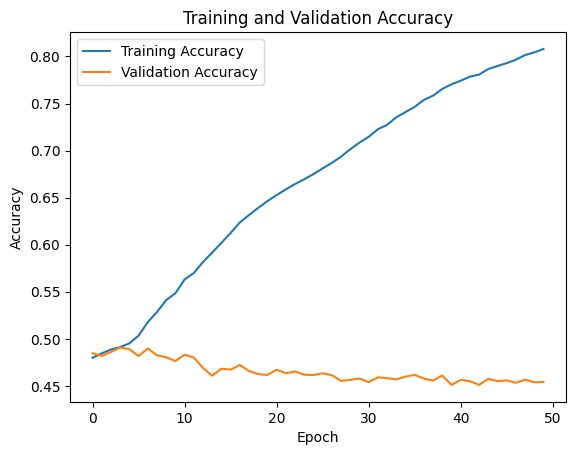

617/617 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
AUROC for class 0: 0.6534974726556753
AUROC for class 1: 0.5959999991678264
AUROC for class 2: 0.5530631805589798


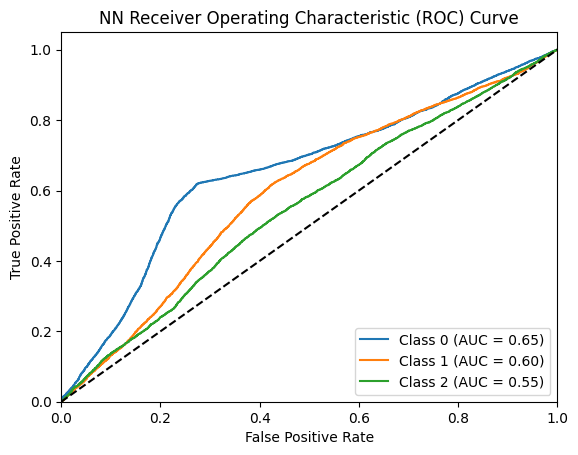

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Define the neural network model
model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history_1 = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)
model_results_validation_accuracy.append(accuracy)
model_results_validation_loss.append(loss)

# Print training accuracy
train_accuracy = history_1.history['accuracy'][-1]
print("Train Accuracy:", train_accuracy)

# Plot training history
plt.plot(history_1.history['accuracy'], label='Training Accuracy')
plt.plot(history_1.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Calculate and plot ROC AUC for Neural Network
y_pred_prob_nn = model.predict(X_test)
n_classes = 3
y_test_bin = label_binarize(y_test, classes=range(n_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob_nn[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Print or display ROC AUC for each class
for i in range(n_classes):
    print(f"AUROC for class {i}: {roc_auc[i]}")

# Plot ROC curves for each class (optional)
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('NN Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()





(98637, 150, 4, 1)
(98637,)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
2466/2466 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.4736 - loss: 0.9839 - val_accuracy: 0.5735 - val_loss: 0.9106
Epoch 2/50
2466/2466 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.5787 - loss: 0.8995 - val_accuracy: 0.6017 - val_loss: 0.8722
Epoch 3/50
2466/2466 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6080 - loss: 0.8578 - val_accuracy: 0.6002 - val_loss: 0.8722
Epoch 4/50
2466/2466 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6248 - loss: 0.8311 - val_accuracy: 0.6193 - val_loss: 0.8500
Epoch 5/50
2466/2466 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6348 - loss: 0.8128 - val_accuracy: 0.6188 - val_loss: 0.8518
Epoch 6/50
2466/2466 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6492 - loss: 0.7834 - val_accuracy: 0.6135 - val_loss: 0.8684
Epoch 7/50
2466/2466 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6714 - loss: 0.7481 - val_accuracy: 0.6017 - val_loss: 0.8840
Epoch 8/50
2466/2466 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6931 - loss: 0.7071 -

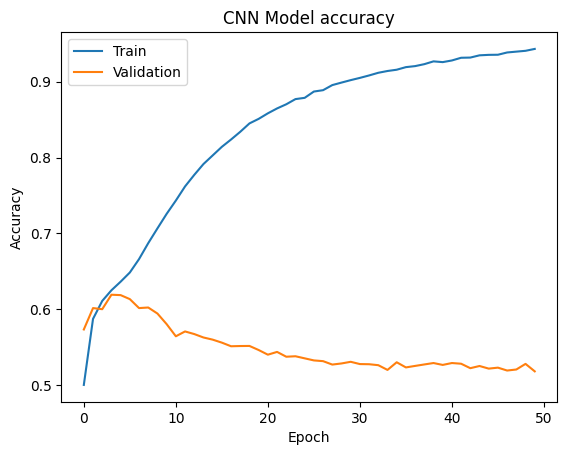

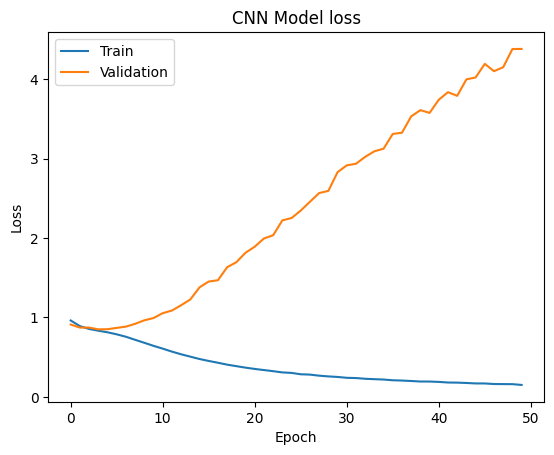

617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
AUROC for class 0: 0.6990271154859372
AUROC for class 1: 0.7189515492356635
AUROC for class 2: 0.6567985876164006


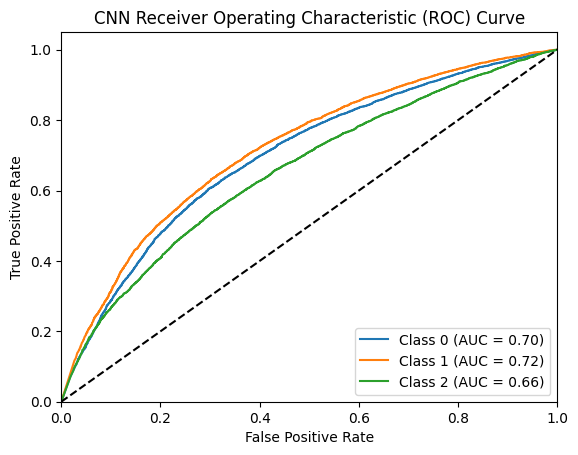

In [105]:
X = np.array(balanced_df['encoded'].tolist())
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

print (X.shape)
print (y.shape)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define the CNN model - Reduced size
model = keras.Sequential([
    layers.Conv2D(16, (3, 4), activation='relu', input_shape=X_train.shape[1:]),
    layers.MaxPooling2D((2, 1)),
    layers.Conv2D(32, (3, 1), activation='relu'),
    layers.MaxPooling2D((2, 1)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(3, activation='softmax')
])


# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Train the model
history_2 = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy:", accuracy)
model_results_validation_accuracy.append(accuracy)
model_results_validation_loss.append(loss)

# Print training accuracy
train_accuracy = history_2.history['accuracy'][-1]
print("Train Accuracy:", train_accuracy)


# Plot training & validation accuracy values
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('CNN Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('CNN Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Calculate and plot ROC AUC for Neural Network
y_pred_prob_nn = model.predict(X_test)
n_classes = 3
y_test_bin = label_binarize(y_test, classes=range(n_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob_nn[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Print or display ROC AUC for each class
for i in range(n_classes):
    print(f"AUROC for class {i}: {roc_auc[i]}")

# Plot ROC curves for each class (optional)
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CNN Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



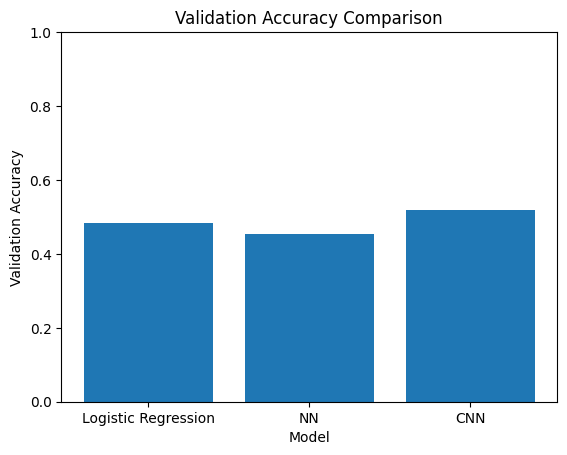

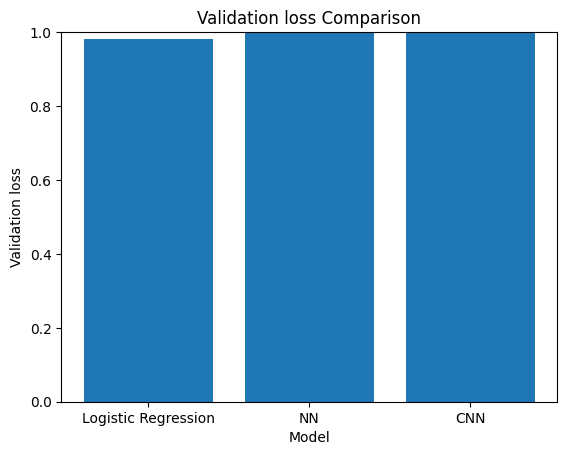

In [106]:
#Comparison between the three models

models = ['Logistic Regression', 'NN', 'CNN']
validation_accuracy = model_results_validation_accuracy

plt.bar(models, validation_accuracy)
plt.xlabel('Model')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Comparison')
plt.ylim([0, 1])
plt.show()

#Comparison between the three models

models = ['Logistic Regression', 'NN', 'CNN']
validation_loss = model_results_validation_loss

plt.bar(models, validation_loss)
plt.xlabel('Model')
plt.ylabel('Validation loss')
plt.title('Validation loss Comparison')
plt.ylim([0, 1])
plt.show()

(98637, 150, 4, 1)
(98637,)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
4932/4932 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.4744 - loss: 1.0969 - val_accuracy: 0.4946 - val_loss: 0.9829
Epoch 2/20
4932/4932 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.5038 - loss: 0.9699 - val_accuracy: 0.5159 - val_loss: 0.9650
Epoch 3/20
4932/4932 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.5472 - loss: 0.9429 - val_accuracy: 0.5953 - val_loss: 0.8998
Epoch 4/20
4932/4932 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.5999 - loss: 0.8846 - val_accuracy: 0.6109 - val_loss: 0.8694
Epoch 5/20
4932/4932 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.6215 - loss: 0.8591 - val_accuracy: 0.6217 - val_loss: 0.8567
Epoch 6/20
4932/4932 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.6285 - loss: 0.8476 - val_accuracy: 0.6261 - val_loss: 0.8460
Epoch 7/20
4932/4932 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.6371 - loss: 0.8324 - val_accuracy: 0.6343 - val_loss: 0.8388
Epoch 8/20
4932/4932 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.6462 - loss: 0

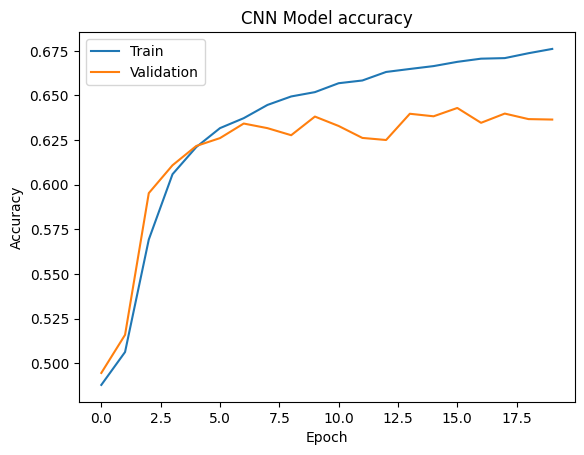

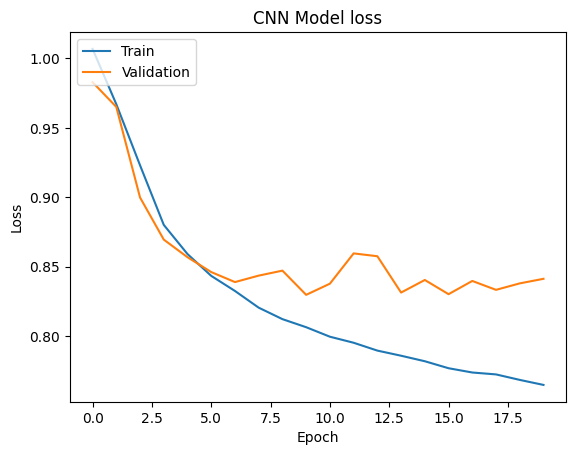

617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
AUROC for class 0: 0.811768050736365
AUROC for class 1: 0.8437888610837315
AUROC for class 2: 0.7753721367902746


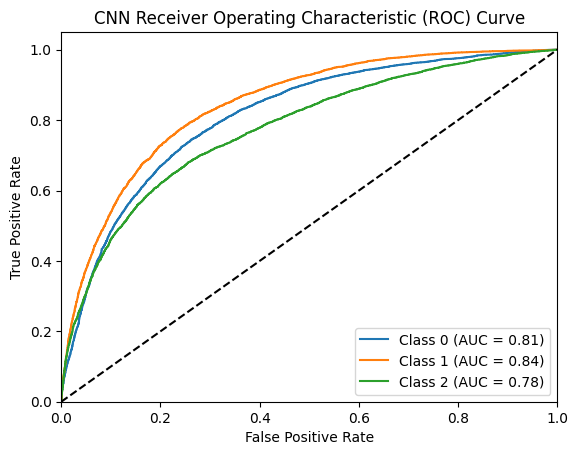

In [107]:
X = np.array(balanced_df['encoded'].tolist())
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

print (X.shape)
print (y.shape)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define the CNN model
model = keras.Sequential([
    layers.Conv2D(16, (3, 4), activation='relu', input_shape=X_train.shape[1:]),
    layers.MaxPooling2D((2, 1)),
    layers.Conv2D(32, (3, 1), activation='relu'),
    layers.MaxPooling2D((2, 1)),
    layers.Conv2D(64, (3, 1), activation='relu'),
    layers.MaxPooling2D((2, 1)),
    layers.Conv2D(128, (3, 1), activation='relu'),
    layers.MaxPooling2D((2, 1)),
    layers.Flatten(),
    layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l1(0.001) ),
    layers.Dense(3, activation='softmax')
])


# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Train the model
history_2 = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy:", accuracy)
model_results_validation_accuracy.append(accuracy)
model_results_validation_loss.append(loss)

# Print training accuracy
train_accuracy = history_2.history['accuracy'][-1]
print("Train Accuracy:", train_accuracy)


# Plot training & validation accuracy values
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('CNN Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('CNN Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Calculate and plot ROC AUC for Neural Network
y_pred_prob_nn = model.predict(X_test)
n_classes = 3  # Assuming you have 3 classes
y_test_bin = label_binarize(y_test, classes=range(n_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob_nn[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Print or display ROC AUC for each class
for i in range(n_classes):
    print(f"AUROC for class {i}: {roc_auc[i]}")

# Plot ROC curves for each class (optional)
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CNN Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


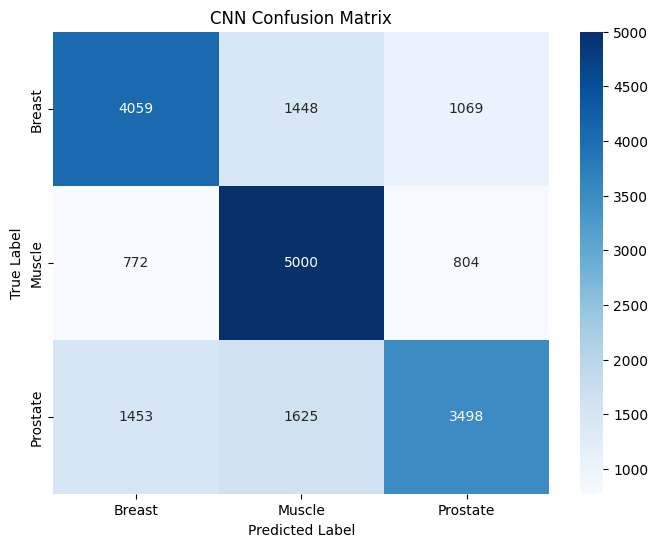

In [108]:
# Get predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Breast', 'Muscle', 'Prostate'],
            yticklabels=['Breast', 'Muscle', 'Prostate'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('CNN Confusion Matrix')
plt.show()

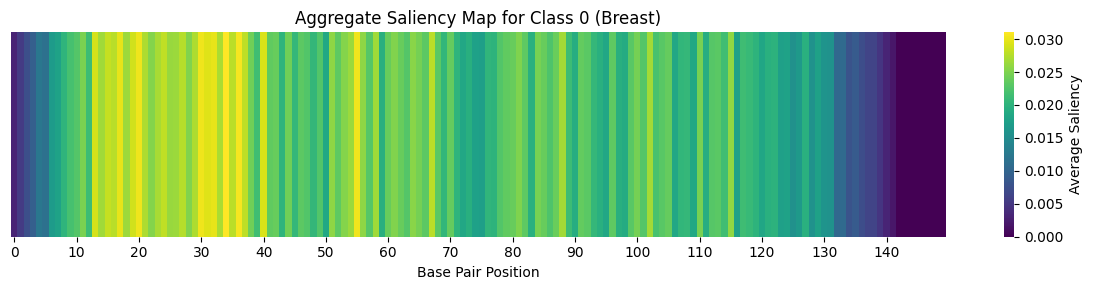

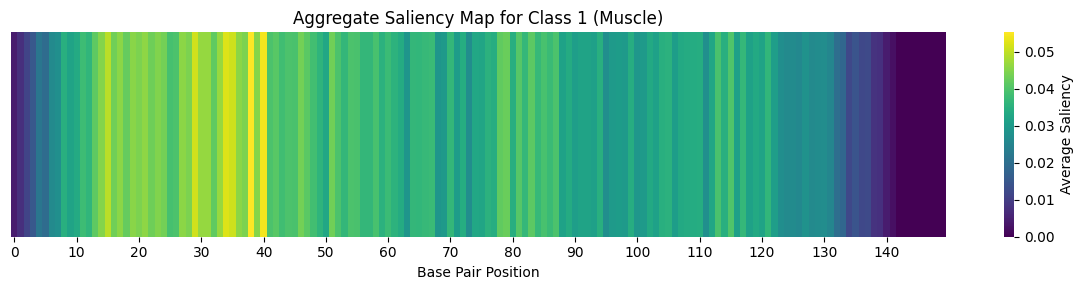

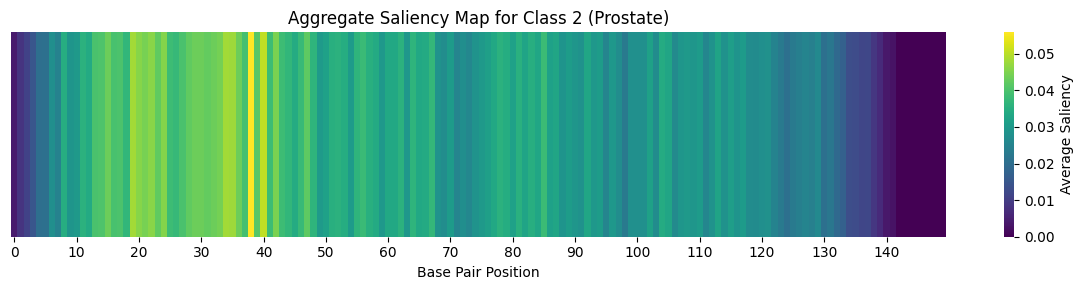

In [109]:
def compute_saliency_matrix(model, input_sequence, class_index):
  """Computes the saliency matrix for a given input sequence and class."""
  input_sequence = tf.convert_to_tensor(input_sequence, dtype=tf.float32)
  with tf.GradientTape() as tape:
    tape.watch(input_sequence)
    logits = model(input_sequence)
    score = logits[0, class_index]
  gradients = tape.gradient(score, input_sequence)
  saliency_matrix = tf.reduce_max(tf.abs(gradients), axis=-1)
  saliency_matrix = saliency_matrix.numpy().squeeze()
  return saliency_matrix

def compute_aggregate_saliency_map(model, X_test, class_index, num_samples=100):
  """Computes the aggregate saliency map for a given class."""
  saliency_matrices = []
  for i in range(num_samples):
    input_sequence = X_test[i:i + 1]
    saliency_matrix = compute_saliency_matrix(model, input_sequence, class_index)
    saliency_matrices.append(saliency_matrix)

  # Aggregate saliency matrices (e.g., by averaging)
  aggregate_saliency_map = np.mean(saliency_matrices, axis=0)
  return aggregate_saliency_map


class_index = 0
aggregate_saliency_map = compute_aggregate_saliency_map(model, X_test, class_index)

if aggregate_saliency_map.ndim == 2:

    saliency_1d = np.max(aggregate_saliency_map, axis=1)
else:
    saliency_1d = aggregate_saliency_map

# Visualize the aggregate saliency map using a heatmap
plt.figure(figsize=(12, 3))
sns.heatmap(
    saliency_1d.reshape(1, -1),
    cmap="viridis",
    cbar_kws={'label': 'Average Saliency'},
    xticklabels=10,
    yticklabels=False
)
plt.xlabel("Base Pair Position")
plt.title(f"Aggregate Saliency Map for Class {class_index} (Breast)")
plt.tight_layout()
plt.show()


class_index = 1
aggregate_saliency_map = compute_aggregate_saliency_map(model, X_test, class_index)

if aggregate_saliency_map.ndim == 2:
    # take the max across the nucleotide axis
    saliency_1d = np.max(aggregate_saliency_map, axis=1)
else:
    saliency_1d = aggregate_saliency_map

# Visualize the aggregate saliency map using a heatmap
plt.figure(figsize=(12, 3))
sns.heatmap(
    saliency_1d.reshape(1, -1),
    cmap="viridis",
    cbar_kws={'label': 'Average Saliency'},
    xticklabels=10,
    yticklabels=False
)
plt.xlabel("Base Pair Position")
plt.title(f"Aggregate Saliency Map for Class {class_index} (Muscle)")
plt.tight_layout()
plt.show()



class_index = 2
aggregate_saliency_map = compute_aggregate_saliency_map(model, X_test, class_index)

if aggregate_saliency_map.ndim == 2:

    saliency_1d = np.max(aggregate_saliency_map, axis=1)
else:
    saliency_1d = aggregate_saliency_map

# Visualize the aggregate saliency map using a heatmap
plt.figure(figsize=(12, 3))
sns.heatmap(
    saliency_1d.reshape(1, -1),
    cmap="viridis",
    cbar_kws={'label': 'Average Saliency'},
    xticklabels=10,
    yticklabels=False
)
plt.xlabel("Base Pair Position")
plt.title(f"Aggregate Saliency Map for Class {class_index} (Prostate)")
plt.tight_layout()
plt.show()


In [110]:
saliency_1d = np.max(aggregate_saliency_map, axis=1)
def extract_best_consecutive_bps(saliency_1d, window_size=15):

    window_sums = np.convolve(saliency_1d, np.ones(window_size), mode='valid')
    start = np.argmax(window_sums)
    return np.arange(start, start + window_size)

best_bps_per_class = {}
for class_index in [0,1,2]:
    agg_sal = compute_aggregate_saliency_map(model, X_test, class_index)
    saliency_1d = np.max(agg_sal, axis=1)
    best_bps  = extract_best_consecutive_bps(saliency_1d, window_size=15)
    best_bps_per_class[class_index] = best_bps
    print(f"Class {class_index} window: {best_bps}")

Class 0 window: [23 24 25 26 27 28 29 30 31 32 33 34 35 36 37]
Class 1 window: [26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
Class 2 window: [28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]


<Figure size 800x200 with 0 Axes>

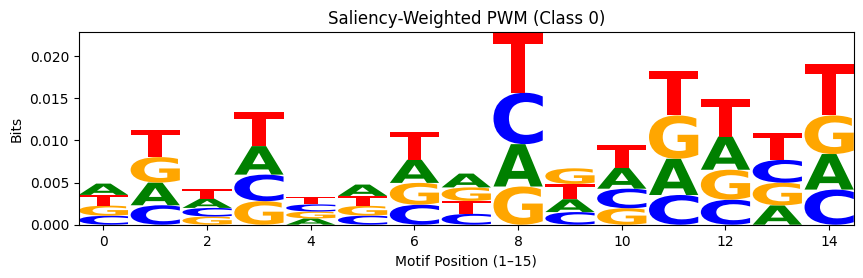

<Figure size 800x200 with 0 Axes>

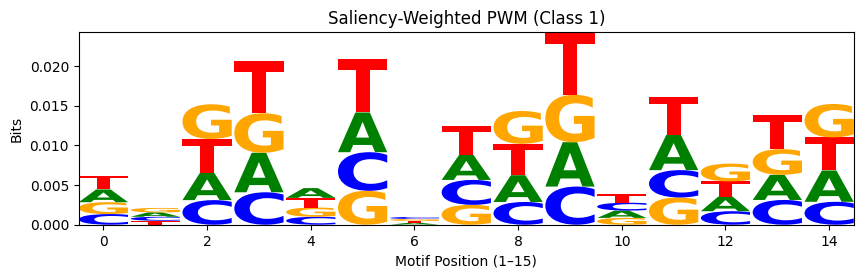

<Figure size 800x200 with 0 Axes>

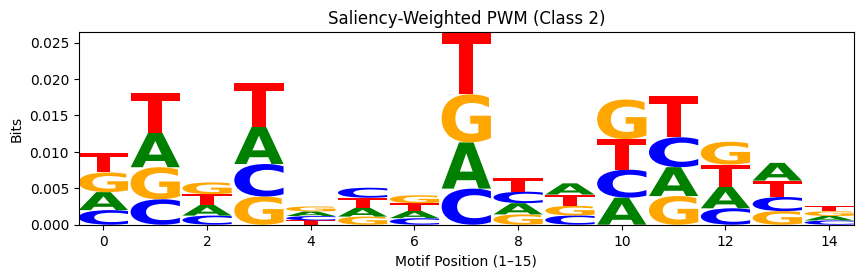

In [111]:
for class_index in [0,1,2]:
    # 1) Compute the averaged 150×4 saliency map
    agg_sal = compute_aggregate_saliency_map(model, X_test, class_index)

    # 2) Collapse to 1D and find the best 15-bp window
    saliency_1d = np.max(agg_sal, axis=1)
    best_bps    = extract_best_consecutive_bps(saliency_1d, window_size=15)

    # 3) Build the saliency-weighted PWM for that window
    M = np.zeros((15,4))
    for seq in X_test:
        onehot = seq[:,:,0]
        win    = onehot[best_bps]
        salwin = agg_sal[best_bps]
        M     += win * salwin
    P = M / M.sum(axis=1, keepdims=True)

    # 4) Convert to information‐content and plot
    df      = pd.DataFrame(P, columns=['A','C','G','T'])
    info_df = lm.transform_matrix(df,
                                  from_type='probability',
                                  to_type='information',
                                  background=[0.25]*4)

    plt.figure(figsize=(8,2))
    logo = lm.Logo(info_df, shade_below=0.5, fade_below=0.5)
    logo.ax.set_title(f"Saliency‐Weighted PWM (Class {class_index})")
    logo.ax.set_xlabel("Motif Position (1–15)")
    logo.ax.set_ylabel("Bits")
    plt.show()